$$\log p(\phi | \{x_i\}) \approx \prod\limits_{i=1}^N \frac{1}{S_i} \sum\limits_{j=1}^{S_i} p(\theta_{ij} | \phi)$$

For normalizing flows 
$$p(\theta_{ij} | \phi) = q_\phi(\theta_{ij})$$

Then a MAP solution for $\phi$ can be obtained by maximizing $\log p(\phi | \{ x_i \})$, which is equivalent to maximizing
$$\sum_{i=1}^N \log \sum\limits_{j=1}^S q_\phi(\theta_{ij})$$


In [1]:
import os
import h5py 
import glob
import numpy as np

In [2]:
from nflows import transforms, distributions, flows

import torch
from torch import nn
from torch import optim

In [3]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
dat_dir = '/tigress/chhahn/provabgs/svda'

In [5]:
if torch.cuda.is_available(): 
    device = torch.device(type='cuda', index=0)
else: 
    device = 'cpu'

# compile $M_*$ posterior data

In [9]:
logM_posteriors, zmaxes = [], []
for fpost in glob.glob(os.path.join(dat_dir, 'provabgs-*.mstar_zmax.hdf5')): 
    f = h5py.File(fpost, 'r')
    mcmc = f['logM'][...]

    #mcmc = f['samples'][...][:,-100:,:,0]
    logM_posteriors.append(mcmc)#mcmc.reshape((mcmc.shape[0], mcmc.shape[1] * mcmc.shape[2])))
    zmaxes.append(f['zmax'][...])
logM_posteriors = np.concatenate(logM_posteriors, axis=0)
zmaxes = np.concatenate(zmaxes, axis=0)

In [10]:
print(logM_posteriors.shape[0])

131


(8.0, 12.5)

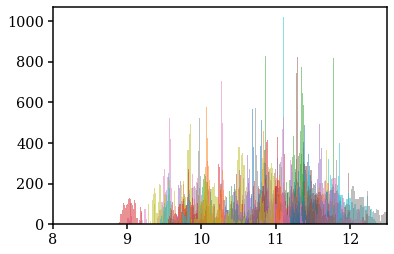

In [11]:
for i in np.random.choice(np.arange(logM_posteriors.shape[0]), size=100, replace=False): 
    plt.hist(logM_posteriors[i,:], bins=40, alpha=0.5)
plt.xlim(8., 12.5)

# calculate $V_{\rm max}$

In [14]:
from astropy.cosmology import Planck13

In [25]:
logM_posteriors[np.isnan(zmaxes)]

array([10.98170406, 10.9781869 , 10.97819335, 10.98057558, 10.97788442,
       10.97581326, 10.97622628, 10.9813832 , 10.97635429, 10.97690393,
       10.98217002, 10.98147413, 10.97836425, 11.79284278, 11.79374631,
       11.79578541, 11.79635667, 11.79600212, 11.79579857, 11.79543523,
       11.7943547 , 11.79388222, 11.7938954 , 11.79429318, 11.794353  ,
       11.79404234, 11.79472022, 11.79563025, 11.79562672, 11.7963143 ,
       11.79664555, 11.79639502, 11.79610949, 11.79567968, 11.79343515,
       11.79388527, 11.78940248, 11.7905469 , 11.79040797, 11.79179898,
       11.78694877, 11.78747369, 11.78255637, 11.79305527, 11.79315827,
       11.79303189, 11.79292366, 11.79291953, 11.79317036, 11.79148656,
       11.79147027, 11.79161133])

In [17]:
Vmaxes = Planck13.comoving_volume(zmaxes).value / 1e9 # Gpc^3

In [20]:
np.median(logM_posteriors, axis=1)

array([10.87596488, 11.2407812 , 11.74207099, 10.09430099, 11.71153342,
       10.40104323,  9.97997924, 11.70049842, 11.10293023, 11.97946705,
       11.64869985,  9.81482549, 10.06827605, 10.36319825, 11.30395644,
       11.28927635, 11.20277123, 10.2731856 , 11.07600885, 11.0812078 ,
       11.3900757 , 11.04960628, 11.31855896, 11.21313303, 10.7932972 ,
       11.4059849 , 10.94188391, 10.78946241, 10.81283925,  9.8216213 ,
       11.01289743, 10.81360023,  9.95466863, 10.92128442, 10.43661956,
       11.27258064, 12.05278006, 11.24626157, 10.27403144,  9.77367417,
       11.68185949,  9.57255535, 11.50979371, 11.25877885, 11.34951816,
       11.51701323, 11.00603724, 10.27602641, 11.25144977, 12.1205982 ,
        9.55380319, 11.96124149, 10.13857504,  9.8231176 , 11.36722309,
       10.82737373, 11.3720579 , 10.85622938, 10.56600441,  9.54017159,
       11.60724837, 10.97222678, 11.28459077, 10.42344393, 10.37284838,
        9.97992698, 10.46658926,  9.79385242, 11.13994337, 11.37

In [26]:
np.nanmedian(zmaxes, axis=1)

array([0.28256634, 0.30538915, 0.47209552, 0.13377644, 0.29091244,
       0.15780389, 0.12818955, 0.37575736, 0.27771836, 0.27846178,
       0.36140801, 0.08202562, 0.12901117, 0.1407015 , 0.29560632,
       0.30368267, 0.29821898, 0.18426824, 0.34055271, 0.26909108,
       0.32075883, 0.27864277, 0.30368321, 0.35058515, 0.25276326,
       0.26336357, 0.23698348, 0.24613946, 0.28465373, 0.09932603,
       0.27229627, 0.20724585, 0.11105272, 0.28526469, 0.22004015,
       0.34125725, 0.43290719, 0.31982196, 0.12801053, 0.08076487,
       0.38370388, 0.0808025 , 0.37470754, 0.28451062, 0.23587301,
       0.3988956 , 0.28533851, 0.1104448 , 0.30744164, 0.53111397,
       0.07926675, 0.50421612, 0.13234824, 0.1078889 , 0.24724979,
       0.20447125, 0.29426798, 0.15151979, 0.19359526, 0.06628915,
       0.41772116, 0.23459261, 0.28558154, 0.10298366, 0.15416638,
       0.09735115, 0.22268869, 0.13837804, 0.24035511, 0.33477373,
       0.31998823, 0.28945717, 0.1637193 , 0.23950405, 0.38771

In [18]:
Vmaxes

array([[ 6.63501844,  3.48620501,  3.78103881, ...,  9.25276852,
         3.81987052,  3.6596606 ],
       [10.24355601, 10.11780942, 10.02851488, ..., 10.1450151 ,
        10.18158667,  7.89378057],
       [26.59879054, 26.59842724, 26.64918903, ..., 26.75186164,
        26.40531817, 26.5046925 ],
       ...,
       [ 0.36036914,  0.3582471 ,  0.35177552, ...,  0.35607122,
         0.35373505,  0.35830041],
       [13.50417978, 13.50647401, 12.09938873, ..., 13.5379744 ,
         8.08264014, 13.68496752],
       [ 1.9241159 ,  1.21804326,  1.2487904 , ...,  1.24573187,
         1.95304849,  1.26510206]])

# estimate $p(M_* | \{x_i, z_i \})$ using NDE

In [11]:
x_data = torch.tensor(logM_posteriors.astype(np.float32)).to(device)
avg_post = torch.mean(x_data)
std_post = torch.std(x_data)
w_post = (x_data - avg_post)/std_post

In [12]:
batch_size = 256
Ntrain = int(0.8 * w_post.shape[0])
Nvalid = int(0.1 * w_post.shape[0])

trainloader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(w_post[:Ntrain]),
        batch_size=batch_size,
        shuffle=False)

validloader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(w_post[Ntrain:Ntrain+Nvalid]),
        batch_size=batch_size)

In [13]:
def Loss(flow, post): 
    return -torch.sum(torch.logsumexp(flow.log_prob(post.flatten()[:,None]).reshape(post.shape), axis=1))

In [14]:
ndim = 1 

In [15]:
nhidden = int(np.ceil(np.exp(np.random.uniform(np.log(64), np.log(256)))))

blocks = []
for iblock in range(5): 
    blocks += [
        transforms.MaskedAffineAutoregressiveTransform(features=ndim, hidden_features=nhidden),
        transforms.RandomPermutation(features=ndim)
    ]

transform = transforms.CompositeTransform(blocks)

# Define a base distribution.
base_distribution = distributions.StandardNormal(shape=[ndim])

In [21]:
all_flows = []

lr = 1e-4
num_iter = 1000
patience = 20

best_valid_losses, valid_losseses = [], []
for i in range(5): 
    nhidden = int(np.ceil(np.exp(np.random.uniform(np.log(64), np.log(256)))))
    print('5x%i' % nhidden)
    blocks = []
    for iblock in range(5): 
        blocks += [
            transforms.MaskedAffineAutoregressiveTransform(features=ndim, hidden_features=nhidden),
            transforms.RandomPermutation(features=ndim)
        ]
    transform = transforms.CompositeTransform(blocks)

    # Define a base distribution.
    base_distribution = distributions.StandardNormal(shape=[ndim])

    # Combine into a flow.
    flow = flows.Flow(transform=transform, distribution=base_distribution)
    flow.to(device)

    # parameters = [weights, means, stdevs]
    optimizer1 = optim.Adam(flow.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer1, lr, total_steps=num_iter)

    best_epoch = 0 
    best_valid_loss = np.inf
    valid_losses = []
    for epoch in range(num_iter):
        train_loss = 0.
        for batch in trainloader: 
            optimizer1.zero_grad()
            loss = Loss(flow, batch[0])
            loss.backward()
            train_loss += loss.item()
            optimizer1.step()
        train_loss /= len(trainloader.dataset)

        with torch.no_grad():
            valid_loss = 0.
            for batch in validloader: 
                loss = Loss(flow, batch[0])
                valid_loss += loss.item()
            valid_loss /= len(validloader.dataset)           
            valid_losses.append(valid_loss)
            
            if epoch % 20 == 0: 
                print('%i \t %.2e \t %.2e' % (epoch, train_loss, valid_loss))
            if valid_loss < best_valid_loss: 
                best_valid_loss = valid_loss
                best_epoch = epoch
            else: 
                if best_epoch < epoch - patience: 
                    print('>>>%i \t %.5e' % (epoch, best_valid_loss))
                    break
                    
        scheduler.step()
    all_flows.append(flow)
    valid_losseses.append(valid_losses)   
    best_valid_losses.append(best_valid_loss)

5x245
0 	 -5.56e+00 	 -5.57e+00
20 	 -6.14e+00 	 -6.15e+00
40 	 -6.60e+00 	 -6.52e+00
>>>58 	 -6.52642e+00
5x113
0 	 -5.65e+00 	 -5.65e+00
20 	 -5.88e+00 	 -5.88e+00
40 	 -6.21e+00 	 -6.21e+00
60 	 -6.58e+00 	 -6.52e+00
80 	 -6.60e+00 	 -6.52e+00
>>>84 	 -6.52659e+00
5x75
0 	 -4.47e+00 	 -4.48e+00
20 	 -4.65e+00 	 -4.66e+00
40 	 -4.92e+00 	 -4.93e+00
60 	 -5.41e+00 	 -5.43e+00
80 	 -6.18e+00 	 -6.19e+00
100 	 -6.60e+00 	 -6.52e+00
>>>116 	 -6.52660e+00
5x135
0 	 -5.02e+00 	 -5.03e+00
20 	 -5.34e+00 	 -5.34e+00
40 	 -5.83e+00 	 -5.85e+00
60 	 -6.53e+00 	 -6.49e+00
80 	 -6.60e+00 	 -6.52e+00
>>>85 	 -6.52634e+00
5x158
0 	 -4.21e+00 	 -4.22e+00
20 	 -4.64e+00 	 -4.66e+00
40 	 -5.35e+00 	 -5.37e+00
60 	 -6.48e+00 	 -6.45e+00
80 	 -6.60e+00 	 -6.52e+00
100 	 -6.60e+00 	 -6.52e+00
>>>100 	 -6.52200e+00


(0.0, 117.0)

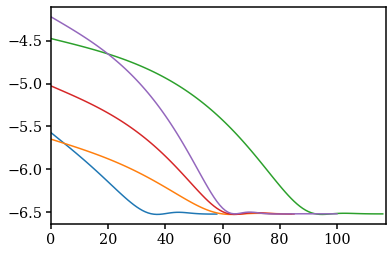

In [26]:
for vl in valid_losseses: 
    plt.plot(np.array(vl))
#plt.ylim(1e4, 2e4)
plt.xlim(0, np.max([len(vl) for vl in valid_losseses]))

In [29]:
#i_best = np.argmin(best_valid_losses)
i_best = 2
print(i_best)

2


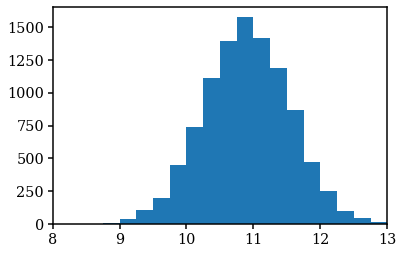

In [30]:
with torch.no_grad(): 
    w_prime = all_flows[i_best].sample(10000)
    post_prime = w_prime * std_post + avg_post
    
plt.hist(np.array(post_prime.detach().cpu()), range=(8., 13.), bins=20)
plt.xlim(8., 13.)
plt.show()